In [1]:
%pip install yfinance finta Jinja2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tickerData import *
from mlAlgorithms import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = getTickerData(ticker="btc-usd", period="max", interval="1d")
df.drop(columns={'Adj Close'}, inplace=True)
df.rename(columns={'Date':'date', 'Open':'open', 'High':'high','Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)
df = exponential_smooth(df, 0.65)
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
0,465.864014,468.174011,452.421997,457.334015,2.105680e+07
1,459.194363,459.793251,423.297558,432.968080,3.100228e+07
2,435.363215,438.089849,396.971212,407.044759,3.570002e+07
3,408.511636,428.327342,392.293679,408.271672,3.646787e+07
4,408.232853,417.936894,392.873483,402.096310,3.000688e+07
...,...,...,...,...,...
3092,22457.304499,22619.316147,22324.905971,22439.015861,1.624571e+10
3093,22438.466047,22559.582331,22121.037207,22296.505747,2.048354e+10
3094,22294.150031,22370.636531,21852.596030,21920.529062,2.181801e+10
3095,21921.004562,22001.488704,20785.107927,20908.149137,2.737334e+10


In [4]:
indicators = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX', 'VAMA', 'ZLEMA', 'VWAP', 'PPO', 'ATR', 'DMI', 'PIVOT_FIB', 'CFI', 'WTO']
df = getTickerIndicatorData(df, indicators, dropna=True)
df

,open,high,low,close,volume,14 period RSI,MACD,SIGNAL_x,14 period STOCH %K,MFV,...,r3,r4,CFI,WT1.,WT2.,ema50,ema21,ema15,ema5,normVol
14,384.652531,391.360114,378.533200,383.829490,2.846410e+07,23.290118,-5.351451,-3.366197,11.083486,-9.414774e+07,...,400.268960,406.749388,-6.069525e+08,-69.100862,-66.269848,0.944290,0.948508,0.952007,0.968014,1.010540
15,384.220590,387.549096,374.901529,378.137115,2.411794e+07,21.518927,-5.954476,-3.898845,5.925917,-1.059257e+08,...,397.401182,402.301063,-6.926644e+08,-69.239291,-68.814850,0.934992,0.939776,0.943735,0.961509,0.878493
16,378.344856,381.143938,363.823891,366.030786,2.852706e+07,18.326777,-7.089667,-4.551711,3.133613,-1.271830e+08,...,392.843480,397.674850,-8.275686e+08,-71.680906,-69.926768,0.910991,0.916573,0.921212,0.942116,1.032053
17,366.350499,370.316928,339.164253,341.873673,4.068820e+07,13.896852,-9.395107,-5.538161,2.849437,-1.607937e+08,...,387.652919,394.269177,-1.121916e+09,-77.328652,-71.837428,0.859248,0.866071,0.871822,0.898622,1.360788
18,342.018065,351.781571,306.749882,327.987292,6.839113e+07,12.088034,-11.943381,-6.837936,16.656722,-1.646769e+08,...,381.604293,393.504615,-1.538726e+09,-83.187999,-75.359212,0.833501,0.841921,0.849088,0.883070,1.872557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,22457.304499,22619.316147,22324.905971,22439.015861,1.624571e+10,40.321254,-19.217816,218.954907,4.544260,3.955603e+12,...,22855.879048,22997.736539,-4.976324e+14,-29.621412,-20.080503,1.055448,0.992409,0.975079,0.974658,0.801195
3093,22438.466047,22559.582331,22121.037207,22296.505747,2.048354e+10,38.591311,-78.194502,159.525025,6.838005,3.951511e+12,...,22755.489503,22867.954190,-5.002898e+14,-33.838846,-26.557881,1.047744,0.986729,0.970900,0.973584,1.008481
3094,22294.150031,22370.636531,21852.596030,21920.529062,2.181801e+10,34.398226,-153.502643,96.919492,2.461562,3.935415e+12,...,22764.253552,22931.777790,-5.039555e+14,-38.624942,-31.737265,1.029469,0.971411,0.957430,0.964049,1.061063
3095,21921.004562,22001.488704,20785.107927,20908.149137,2.737334e+10,26.156891,-291.515083,19.232577,3.518859,3.913580e+12,...,22565.961042,22763.852513,-5.119932e+14,-46.431468,-37.129167,0.982272,0.929651,0.918527,0.932026,1.261586


In [5]:
df2 = produce_prediction(df, 14, dropna=True, removeohl=True)
df2

,close,volume,14 period RSI,MACD,SIGNAL_x,14 period STOCH %K,MFV,14 period ATR_x,MOM,14 period MFI,...,r4,CFI,WT1.,WT2.,ema50,ema21,ema15,ema5,normVol,pred
14,383.829490,2.846410e+07,23.290118,-5.351451,-3.366197,11.083486,-9.414774e+07,22.959532,-18.266820,31.815877,...,406.749388,-6.069525e+08,-69.100862,-66.269848,0.944290,0.948508,0.952007,0.968014,1.010540,1.0
15,378.137115,2.411794e+07,21.518927,-5.954476,-3.898845,5.925917,-1.059257e+08,21.256094,-23.995465,32.674839,...,402.301063,-6.926644e+08,-69.239291,-68.814850,0.934992,0.939776,0.943735,0.961509,0.878493,1.0
16,366.030786,2.852706e+07,18.326777,-7.089667,-4.551711,3.133613,-1.271830e+08,19.556195,-57.993843,33.536486,...,397.674850,-8.275686e+08,-71.680906,-69.926768,0.910991,0.916573,0.921212,0.942116,1.032053,1.0
17,341.873673,4.068820e+07,13.896852,-9.395107,-5.538161,2.849437,-1.607937e+08,19.207553,-81.618068,33.679531,...,394.269177,-1.121916e+09,-77.328652,-71.837428,0.859248,0.866071,0.871822,0.898622,1.360788,1.0
18,327.987292,6.839113e+07,12.088034,-11.943381,-6.837936,16.656722,-1.646769e+08,20.633858,-87.757310,31.622358,...,393.504615,-1.538726e+09,-83.187999,-75.359212,0.833501,0.841921,0.849088,0.883070,1.872557,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,24674.153226,2.791150e+10,74.231532,698.568054,579.581264,90.332045,3.999054e+12,835.249983,2818.809889,63.533415,...,25582.761973,-4.841354e+14,29.959902,21.974584,1.197590,1.120557,1.086876,1.044901,0.995752,0.0
3079,24519.583414,3.008289e+10,71.373002,723.918861,608.448783,84.047733,3.993016e+12,865.552980,2654.144496,64.147763,...,25920.532112,-4.791839e+14,32.641997,27.161152,1.185668,1.107820,1.074333,1.031760,1.060279,0.0
3080,24304.602633,3.015901e+10,67.480809,718.381353,630.435297,77.992945,3.996607e+12,885.034321,2489.366980,63.117344,...,25886.557140,-4.763115e+14,32.593702,30.281719,1.171247,1.093232,1.060325,1.018857,1.051923,0.0
3081,24072.480843,3.036522e+10,63.456970,687.339329,641.816104,71.455393,3.989492e+12,875.867760,2261.882349,62.726540,...,25470.298788,-4.752429e+14,31.429125,31.656181,1.156432,1.078731,1.046695,1.007594,1.048782,0.0


In [6]:
df2.columns.value_counts().sum()

43

In [7]:
cor_matrix = df2.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
b = df2.drop(columns=to_drop)
b.corr().abs().style.background_gradient(cmap='coolwarm')

,close,volume,14 period RSI,MACD,14 period STOCH %K,MFV,14 period ATR_x,MOM,14 period MFI,ROC,20 period CCI,14 period EMV,VIm,VWAP.,PPO,HISTO,DI+,DI-,CFI,WT1.,ema50,ema5,normVol,pred
close,1.000000,0.742273,0.035876,0.156531,0.018747,0.886834,0.899594,0.074775,0.077438,0.009285,0.042381,0.008888,0.035575,0.805714,0.018425,0.020017,0.145951,0.023636,0.758734,0.033263,0.054673,0.001810,0.020304,0.145122
volume,0.742273,1.000000,0.004226,0.179243,0.006530,0.717485,0.732077,0.044054,0.023356,0.026335,0.017452,0.022357,0.005791,0.636479,0.061018,0.042759,0.052449,0.009233,0.600558,0.025146,0.098516,0.006669,0.122285,0.074427
14 period RSI,0.035876,0.004226,1.000000,0.543845,0.829720,0.108472,0.098319,0.524320,0.823686,0.817758,0.860497,0.491626,0.891590,0.209364,0.824958,0.561583,0.845725,0.843506,0.061766,0.929676,0.738078,0.839564,0.232498,0.112719
MACD,0.156531,0.179243,0.543845,1.000000,0.357936,0.017397,0.040520,0.658715,0.443163,0.501910,0.377079,0.733873,0.437108,0.125992,0.691628,0.189950,0.396389,0.420268,0.325851,0.559343,0.624601,0.432185,0.107057,0.035523
14 period STOCH %K,0.018747,0.006530,0.829720,0.357936,1.000000,0.058897,0.084415,0.528162,0.779045,0.757896,0.890159,0.443113,0.793044,0.126624,0.532136,0.686174,0.597234,0.685174,0.022389,0.720513,0.489566,0.808410,0.188376,0.098971
MFV,0.886834,0.717485,0.108472,0.017397,0.058897,1.000000,0.749156,0.011793,0.130871,0.064166,0.075596,0.068908,0.079635,0.940166,0.098971,0.004489,0.172323,0.022512,0.434956,0.101031,0.137558,0.062681,0.036309,0.104475
14 period ATR_x,0.899594,0.732077,0.098319,0.040520,0.084415,0.749156,1.000000,0.070283,0.145612,0.062281,0.114374,0.150862,0.098951,0.660720,0.029623,0.133939,0.156686,0.055826,0.773281,0.090766,0.090157,0.082880,0.054262,0.114914
MOM,0.074775,0.044054,0.524320,0.658715,0.528162,0.011793,0.070283,1.000000,0.494298,0.641896,0.515301,0.790325,0.477246,0.077464,0.462594,0.561415,0.357970,0.434451,0.103579,0.451469,0.425105,0.617440,0.100008,0.039863
14 period MFI,0.077438,0.023356,0.823686,0.443163,0.779045,0.130871,0.145612,0.494298,1.000000,0.788348,0.773620,0.499142,0.898652,0.202687,0.651880,0.661167,0.678669,0.690846,0.015420,0.810436,0.540915,0.714822,0.205692,0.111360
ROC,0.009285,0.026335,0.817758,0.501910,0.757896,0.064166,0.062281,0.641896,0.788348,1.000000,0.750091,0.618428,0.829123,0.131690,0.743746,0.791508,0.703727,0.701078,0.054812,0.753682,0.668704,0.878185,0.245049,0.064840


In [8]:
features = StandardScaler().fit_transform(df2[df2.columns.difference(['pred', 'date'])])
target = df2['pred']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.4, shuffle=False)
X_train.shape

(1841, 42)

{'n_neighbors': 23}
              precision    recall  f1-score   support

         0.0       0.49      0.82      0.62       568
         1.0       0.64      0.28      0.39       660

    accuracy                           0.53      1228
   macro avg       0.57      0.55      0.50      1228
weighted avg       0.57      0.53      0.49      1228

{'C': 0.1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

         0.0       0.51      0.80      0.63       568
         1.0       0.67      0.35      0.46       660

    accuracy                           0.56      1228
   macro avg       0.59      0.57      0.54      1228
weighted avg       0.60      0.56      0.54      1228

{'n_estimators': 170}
              precision    recall  f1-score   support

         0.0       0.49      0.96      0.65       568
         1.0       0.81      0.14      0.24       660

    accuracy                           0.52      1228
   macro avg       0.65      0.55      0.45      122

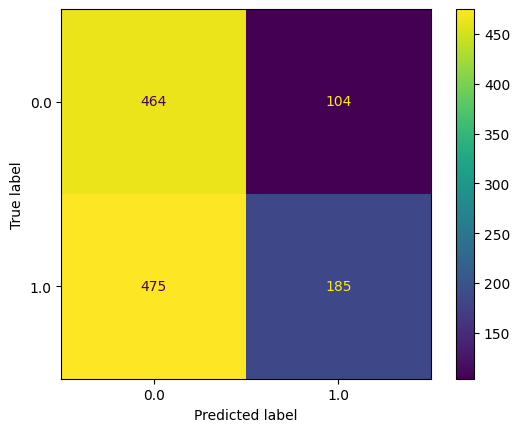

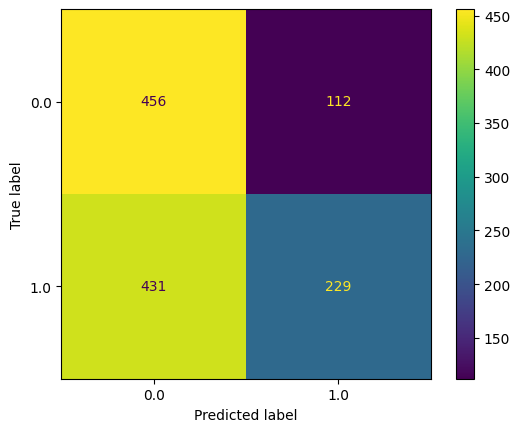

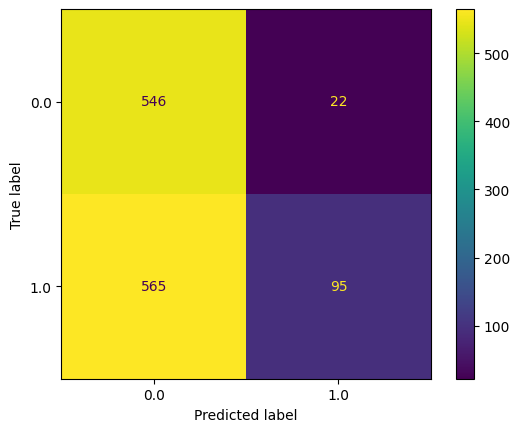

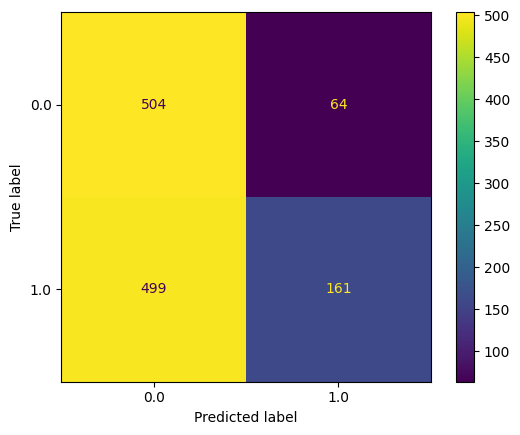

In [9]:
knn = trained_KNN(X_train, X_test, Y_train, Y_test)
lr = trained_LogisticRegression(X_train, X_test, Y_train, Y_test)
rfc = trained_RandomForestClassifier(X_train, X_test, Y_train, Y_test)
vc = trained_VotingClassifier(lr, knn, rfc, X_train, X_test, Y_train, Y_test)

In [11]:
print('knn -', metrics.accuracy_score(df2['pred'], knn.predict(features)))
print('lr -', metrics.accuracy_score(df2['pred'], lr.predict(features)))
print('rfc -', metrics.accuracy_score(df2['pred'], rfc.predict(features)))
print('vc -', metrics.accuracy_score(df2['pred'], vc.predict(features)))

knn - 0.661127403062887
lr - 0.6093189964157706
rfc - 0.5946562398175301
vc - 0.6236559139784946
